In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../imports/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


## Panel C <br>
Data requirement: presentation score matrices (native + mut) for oncogenes, tumor suppressor genes, and random

In [2]:
def get_pre_mutation(x):
    return x[:-1]
def native_letter(x):
    return x.split('_')[1][0]
categories = ['oncogenes', 'oncogenes', 'tsgenes', 'tsgenes', 'random', 'random']
statuses = ['mut', 'native', 'mut', 'native', 'mut', 'native']

In [3]:
mutation_counts = pd.DataFrame(pd.read_csv(PATH_TO_DATA + 'data/patient_mutations.cancer.PHBR.csv', index_col=0).sum()).reset_index()
mutation_counts.columns = ['mutation', 'count']
driver_mutations = list(mutation_counts[mutation_counts['count'] > 10].mutation)

In [4]:
def get_values_from_df(df):
    values = []
    for a in df.values:
        values.extend(a)
    return values

In [5]:
value_types = []
for category, status in zip(categories, statuses):
    if status == 'mut':
        # restrict the columns to higher frequency mutations
        if category == 'oncogenes' or category == 'tsgenes':
            df = pd.read_csv(PATH_TO_DATA + 'data/{0}_allele_matrix.csv'.format(category), index_col=0)
            app_restricted_space = [x for x in driver_mutations if x in df.index]
            values = get_values_from_df(df.transpose()[app_restricted_space].transpose())
            print category, len(values), len(df.index), len(app_restricted_space)
            value_types.append(values)
        else:
            df = pd.read_csv(PATH_TO_DATA + 'data/{0}_allele_matrix.csv'.format(category), index_col=0)
            values = get_values_from_df(df)
            value_types.append(values)
            print category, len(values)
    else:
        # restrict the columns to higher frequency mutations
        if category == 'oncogenes' or category == 'tsgenes':
            df = pd.read_csv(PATH_TO_DATA + 'data/{0}_allele_matrix.native.csv'.format(category), index_col=0)
            app_restricted_space = [x for x in driver_mutations if x in df.index]
            values = get_values_from_df(df.transpose()[app_restricted_space].transpose())
            print category, len(values), len(df.index), len(app_restricted_space)
            value_types.append(values)
        else:
            df = pd.read_csv(PATH_TO_DATA + 'data/{0}_allele_matrix.native.csv'.format(category), index_col=0)
            values = get_values_from_df(df)
            value_types.append(values)
            print category, len(values)

oncogenes 222224 643 76
oncogenes 207604 377 71
tsgenes 204680 602 70
tsgenes 204680 351 70
random 8772000
random 8772000


In [6]:
plotting = pd.DataFrame({'category': ['oncogenes' for x in value_types[0]] + ['oncogenes' for x in value_types[1]] + ['tsgenes' for x in value_types[2]] + ['tsgenes' for x in value_types[3]] + ['random' for x in value_types[4]] + ['random' for x in value_types[5]],
                         'residue': ['mutated' for x in value_types[0]] + ['native' for x in value_types[1]] + ['mutated' for x in value_types[2]] + ['native' for x in value_types[3]] + ['mutated' for x in value_types[4]] + ['native' for x in value_types[5]],
                         'best_rank': value_types[0] + value_types[1] + value_types[2] + value_types[3] + value_types[4] + value_types[5]})

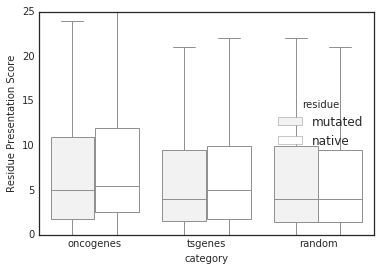

In [7]:
sns.boxplot(x='category', y='best_rank', hue='residue', data=plotting, showfliers=False, color='white')
plt.ylim(0, 25)
plt.ylabel('Residue Presentation Score')

## Panel D <br>
Data requirement: presentation score matrices (native + mut) for oncogenes, tumor suppressor genes, and random

In [8]:
perc_strong, perc_all = [], []
for i, category in enumerate(categories):
    total = len(value_types[i])
    greater_than_strong = len(filter(lambda a: a < 0.5, value_types[i]))
    greater_than_all = len(filter(lambda a: a < 2, value_types[i]))
    print category, float(greater_than_all)/total, float(greater_than_strong)/total
    perc_all.append(float(greater_than_all)/total)
    perc_strong.append(float(greater_than_strong)/total)

oncogenes 0.261888904889 0.0743529051768
oncogenes 0.225178705613 0.0585056164621
tsgenes 0.296071917139 0.072024623803
tsgenes 0.261476451046 0.0642026578073
random 0.317438554492 0.0936664386685
random 0.322212836297 0.0950891472868


In [9]:
binders = pd.DataFrame({'category': categories, 'residue': statuses, 'Perc_strong': perc_strong, 'Perc_all': perc_all})

In [10]:
all_binders = pd.DataFrame({'category': list(binders[binders.residue == 'mut'].category) + list(binders[binders.residue == 'mut'].category) + list(binders[binders.residue == 'native'].category) + list(binders[binders.residue == 'native'].category),
                            'percentage': list(binders[binders.residue == 'mut'].Perc_all) + list(binders[binders.residue == 'mut'].Perc_strong) + list(binders[binders.residue == 'native'].Perc_all) + list(binders[binders.residue == 'native'].Perc_strong),
                            'binding': ['all-mut' for x in list(binders[binders.residue == 'mut'].Perc_all)] + ['strong-mut' for x in list(binders[binders.residue == 'mut'].Perc_strong)] + ['all-native' for x in list(binders[binders.residue == 'native'].Perc_all)] + ['strong-native' for x in list(binders[binders.residue == 'native'].Perc_strong)]})

(0, 0.45)

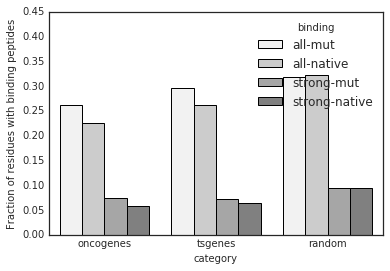

In [11]:
sns.barplot(x='category', y='percentage', hue='binding', data=all_binders, color='grey', hue_order=['all-mut', 'all-native', 'strong-mut', 'strong-native'], order=['oncogenes', 'tsgenes', 'random'])
plt.ylabel('Fraction of residues with binding peptides')
plt.ylim(0, 0.45)